<a href="https://colab.research.google.com/github/dokeyuka/deep-learning-practice/blob/main/DL_practice8_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 最適化手法の工夫・最適解の探索効率を上げる
## 学習率の値は同じだけどパラメータ更新時にmomentum項を用いる
## 学習率：はじめは大きく徐々に小さくすることが実現可能
### 1 momentum: SGDに 移動平均 を適用して、振動を抑制。(ボールがお椀を転がる)
### 2 Nesterov momentm:パラメータの向かう方向を組み込む
### 3 Adagrad:過去の勾配を2乗和としてすべて記録
### 4 RMSProp: 勾配の大きさに応じて 学習率を調整 するようにして、振動を抑制。
### 5 Adadelta
### 6 Adam : momentum + RMSProp。
### 7 AMSGrad


In [ ]:
'''
momentumの実装
optimizer = optimizers.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
'''

epoch:1, loss: 0.983, a㏄:0.696, val_loss:0.328, val_acc:0.907
epoch:2, loss: 0.270, a㏄:0.920, val_loss:0.213, val_acc:0.937
epoch:3, loss: 0.174, a㏄:0.949, val_loss:0.150, val_acc:0.952
epoch:4, loss: 0.127, a㏄:0.964, val_loss:0.133, val_acc:0.959
epoch:5, loss: 0.102, a㏄:0.970, val_loss:0.115, val_acc:0.964
epoch:6, loss: 0.081, a㏄:0.976, val_loss:0.103, val_acc:0.969
epoch:7, loss: 0.068, a㏄:0.980, val_loss:0.098, val_acc:0.970
epoch:8, loss: 0.055, a㏄:0.984, val_loss:0.104, val_acc:0.970
epoch:9, loss: 0.047, a㏄:0.986, val_loss:0.085, val_acc:0.974
epoch:10, loss: 0.041, a㏄:0.988, val_loss:0.079, val_acc:0.976
epoch:11, loss: 0.033, a㏄:0.991, val_loss:0.085, val_acc:0.975
epoch:12, loss: 0.027, a㏄:0.992, val_loss:0.080, val_acc:0.977
epoch:13, loss: 0.024, a㏄:0.993, val_loss:0.086, val_acc:0.976
epoch:14, loss: 0.019, a㏄:0.995, val_loss:0.093, val_acc:0.976
epoch:15, loss: 0.015, a㏄:0.996, val_loss:0.086, val_acc:0.976
epoch:16, loss: 0.013, a㏄:0.997, val_loss:0.087, val_acc:0.978
e

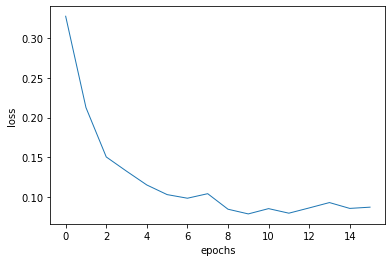

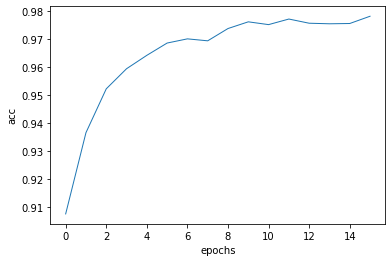

In [ ]:
class EarlyStopping:
  def __init__(self, patience = 0, verbose = 0):
    #self._step 連続で最小値を上回ったepoch数を保持
    self._step = 0
    #self._loss 誤差の最小値を保持
    self._loss = float('inf')
    self.patience = patience
    self.verbose = verbose
  
  def __call__(self, loss):
    if self._loss < loss:
      self._step += 1
      if self._step > self.patience:
        if self.verbose:
          print('early stopping')
          return True
    else:
        self._step = 0
        self._loss = loss
    return False  




import os
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn 
import torch.optim as optimizers
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from matplotlib import pyplot as plt


'''
  (1) modelの実装
'''
class DNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.l1 = nn.Linear(input_dim, hidden_dim)
    self.a1 = nn.ReLU()
    self.d1 = nn.Dropout(0.5)

    self.l2 = nn.Linear(hidden_dim, hidden_dim)
    self.a2 = nn.ReLU()
    self.d2 = nn.Dropout(0.5)

    self.l3 = nn.Linear(hidden_dim,hidden_dim)
    self.a3 = nn.ReLU()
    self.d3 = nn.Dropout(0.5)

    self.l4 = nn.Linear(hidden_dim, output_dim)
    
    self.layers = [self.l1, self.a1,
                    self.l2, self.a2,
                    self.l3, self.a3,
                    self.l4]

  def forward(self,x):
    for layer in self.layers:
      x = layer(x)
    return x



if __name__ == '__main__':
  np.random.seed(123)
  #torch用の乱数シード
  torch.manual_seed(123)

  #deviceに実行環境を格納して同じコードでCPUでもGPUでも対応できるように
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
'''
  1 データの準備
'''
root = os.path.join('~', '.torch', 'mnist')
#numpyをTテンensorに変換し、さらにTensorの次元を(28，28)から(784、)に変換
transform = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])

mnist_train = datasets.MNIST(root = root,
                             download = True,
                             train = True,
                             transform = transform)
n_samples = len(mnist_train)
n_train = int(n_samples * 0.8)
n_val = n_samples - n_train
#2番目の引数 = 分割するデータ数
#8:2に分割して検証データを作る
mnist_train, mnist_val = random_split(mnist_train, [n_train, n_val])


mnist_test = datasets.MNIST(root = root,
                            download = True,
                            train = False,
                            transform = transform)



#学習に用いるためにデータセットをDataLoaderオブジェクトに変換
#minibatch学習の時にバッチ単位でデータ処理できる、かつ、各epochでデータシャッフル可能
train_dataloader = DataLoader(mnist_train, 
                              batch_size = 100,
                              shuffle = True)

test_dataloader = DataLoader(mnist_test,
                             batch_size = 100,
                             shuffle = False)
val_dataloader = DataLoader(mnist_test,
                            batch_size = 100,
                            shuffle = False)

'''
  2 モデルの構築
'''
model = DNN(784, 200, 10).to(device)

'''
  3　モデルの学習
'''
criterion = nn.CrossEntropyLoss()
#momentumの導入
optimizer = optimizers.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

def compute_loss(t, y):
  return criterion(y, t)

def train_step(x, t):
  #dropoutは訓練時とテスト時で挙動が異なるので書き忘れない！
  model.train()
  preds = model(x)
  loss = compute_loss(t, preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss, preds
#勾配を計算する必要がないのでtest_stepと同じ処理
def val_step(x, t):
  model.eval()
  preds = model(x)
  loss = criterion(preds, t)
  return loss, preds

epochs = 1000
#誤差と正解率の推移を保持するためのもの
hist = {'loss':[], 'accuracy':[],'val_loss':[], 'val_accuracy':[]}
es = EarlyStopping(patience = 5, verbose = 1)

for epoch in range(epochs):
  train_loss = 0.
  train_acc = 0.
  val_loss = 0.
  val_acc = 0.

  for(x, t) in train_dataloader:
    x,t = x.to(device), t.to(device)
    loss, preds = train_step(x,t)
    train_loss += loss.item()
    #accuracy_socreはテンソル型をうけとれないので.tolist()を実行
    train_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
  
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  
  for(x, t) in val_dataloader:
    x,t = x.to(device), t.to(device)
    loss, preds = val_step(x,t)
    val_loss += loss.item()
    #accuracy_socreはテンソル型をうけとれないので.tolist()を実行
    val_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
  
  val_loss /= len(val_dataloader)
  val_acc /= len(val_dataloader)


  hist['loss'].append(train_loss)
  hist['accuracy'].append(train_acc)

  hist['val_loss'].append(val_loss)
  hist['val_accuracy'].append(val_acc)


  print('epoch:{}, loss: {:.3f}, a㏄:{:.3f}'
        ', val_loss:{:.3f}, val_acc:{:.3f}'.format(epoch +1,
                                                    train_loss,
                                                    train_acc,
                                                   val_loss,
                                                   val_acc))
  if es(val_loss):#早期終了判定
    break

'''
  4 モデルの評価
'''
#検証データの誤差の可視化
val_loss = hist['val_loss']
val_acc = hist['val_accuracy']
fig = plt.figure()
plt.plot(range(len(val_loss)), val_loss, linewidth = 1)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.figure()
plt.plot(range(len(val_acc)), val_acc, linewidth = 1)
plt.xlabel('epochs')
plt.ylabel('acc')



def test_step(x,t):
  return val_step(x,t)

test_loss = 0.
test_acc = 0.

test_loss = 0.
test_acc = 0.

for(x,t) in test_dataloader:
  x, t = x.to(device), t.to(device)
  loss, preds = test_step(x,t)
  test_loss += loss.item()
  test_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)


print('epoch:{}, loss: {:.3f}, acc:{:.3f}'.format(epoch +1,
                                                    test_loss,
                                                    test_acc))



## 2 Nesterovモメンタム
パラメータの向かう方向を組み込む

In [ ]:
'''
Nestrov momentumの実装
optimizer = optimizers.SGD(model.parameters(), lr = 0.01, momentum = 0.9, Nesterov = True)
'''

epoch:1, loss: 0.963, a㏄:0.704, val_loss:0.326, val_acc:0.907
epoch:2, loss: 0.265, a㏄:0.923, val_loss:0.208, val_acc:0.938
epoch:3, loss: 0.173, a㏄:0.949, val_loss:0.158, val_acc:0.950
epoch:4, loss: 0.127, a㏄:0.963, val_loss:0.136, val_acc:0.959
epoch:5, loss: 0.099, a㏄:0.970, val_loss:0.110, val_acc:0.967
epoch:6, loss: 0.081, a㏄:0.976, val_loss:0.101, val_acc:0.968
epoch:7, loss: 0.066, a㏄:0.980, val_loss:0.092, val_acc:0.972
epoch:8, loss: 0.054, a㏄:0.984, val_loss:0.095, val_acc:0.972
epoch:9, loss: 0.046, a㏄:0.987, val_loss:0.084, val_acc:0.974
epoch:10, loss: 0.039, a㏄:0.988, val_loss:0.081, val_acc:0.976
epoch:11, loss: 0.032, a㏄:0.991, val_loss:0.084, val_acc:0.975
epoch:12, loss: 0.027, a㏄:0.992, val_loss:0.080, val_acc:0.976
epoch:13, loss: 0.022, a㏄:0.994, val_loss:0.087, val_acc:0.975
epoch:14, loss: 0.017, a㏄:0.996, val_loss:0.088, val_acc:0.975
epoch:15, loss: 0.015, a㏄:0.997, val_loss:0.086, val_acc:0.975
epoch:16, loss: 0.012, a㏄:0.997, val_loss:0.090, val_acc:0.976
e

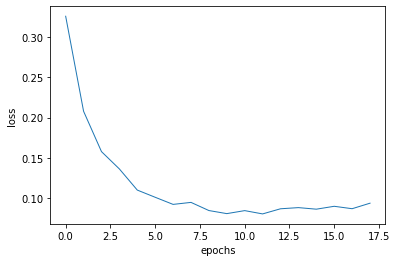

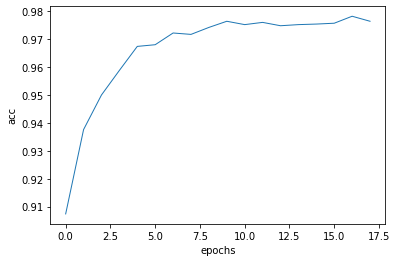

In [ ]:
class EarlyStopping:
  def __init__(self, patience = 0, verbose = 0):
    #self._step 連続で最小値を上回ったepoch数を保持
    self._step = 0
    #self._loss 誤差の最小値を保持
    self._loss = float('inf')
    self.patience = patience
    self.verbose = verbose
  
  def __call__(self, loss):
    if self._loss < loss:
      self._step += 1
      if self._step > self.patience:
        if self.verbose:
          print('early stopping')
          return True
    else:
        self._step = 0
        self._loss = loss
    return False  




import os
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn 
import torch.optim as optimizers
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from matplotlib import pyplot as plt


'''
  (1) modelの実装
'''
class DNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.l1 = nn.Linear(input_dim, hidden_dim)
    self.a1 = nn.ReLU()
    self.d1 = nn.Dropout(0.5)

    self.l2 = nn.Linear(hidden_dim, hidden_dim)
    self.a2 = nn.ReLU()
    self.d2 = nn.Dropout(0.5)

    self.l3 = nn.Linear(hidden_dim,hidden_dim)
    self.a3 = nn.ReLU()
    self.d3 = nn.Dropout(0.5)

    self.l4 = nn.Linear(hidden_dim, output_dim)
    
    self.layers = [self.l1, self.a1,
                    self.l2, self.a2,
                    self.l3, self.a3,
                    self.l4]

  def forward(self,x):
    for layer in self.layers:
      x = layer(x)
    return x



if __name__ == '__main__':
  np.random.seed(123)
  #torch用の乱数シード
  torch.manual_seed(123)

  #deviceに実行環境を格納して同じコードでCPUでもGPUでも対応できるように
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
'''
  1 データの準備
'''
root = os.path.join('~', '.torch', 'mnist')
#numpyをTテンensorに変換し、さらにTensorの次元を(28，28)から(784、)に変換
transform = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])

mnist_train = datasets.MNIST(root = root,
                             download = True,
                             train = True,
                             transform = transform)
n_samples = len(mnist_train)
n_train = int(n_samples * 0.8)
n_val = n_samples - n_train
#2番目の引数 = 分割するデータ数
#8:2に分割して検証データを作る
mnist_train, mnist_val = random_split(mnist_train, [n_train, n_val])


mnist_test = datasets.MNIST(root = root,
                            download = True,
                            train = False,
                            transform = transform)



#学習に用いるためにデータセットをDataLoaderオブジェクトに変換
#minibatch学習の時にバッチ単位でデータ処理できる、かつ、各epochでデータシャッフル可能
train_dataloader = DataLoader(mnist_train, 
                              batch_size = 100,
                              shuffle = True)

test_dataloader = DataLoader(mnist_test,
                             batch_size = 100,
                             shuffle = False)
val_dataloader = DataLoader(mnist_test,
                            batch_size = 100,
                            shuffle = False)

'''
  2 モデルの構築
'''
model = DNN(784, 200, 10).to(device)

'''
  3　モデルの学習
'''
criterion = nn.CrossEntropyLoss()
#Nesterovモメンタムの導入
optimizer = optimizers.SGD(model.parameters(), lr = 0.01, momentum = 0.9, nesterov = True)

def compute_loss(t, y):
  return criterion(y, t)

def train_step(x, t):
  #dropoutは訓練時とテスト時で挙動が異なるので書き忘れない！
  model.train()
  preds = model(x)
  loss = compute_loss(t, preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss, preds
#勾配を計算する必要がないのでtest_stepと同じ処理
def val_step(x, t):
  model.eval()
  preds = model(x)
  loss = criterion(preds, t)
  return loss, preds

epochs = 1000
#誤差と正解率の推移を保持するためのもの
hist = {'loss':[], 'accuracy':[],'val_loss':[], 'val_accuracy':[]}
es = EarlyStopping(patience = 5, verbose = 1)

for epoch in range(epochs):
  train_loss = 0.
  train_acc = 0.
  val_loss = 0.
  val_acc = 0.

  for(x, t) in train_dataloader:
    x,t = x.to(device), t.to(device)
    loss, preds = train_step(x,t)
    train_loss += loss.item()
    #accuracy_socreはテンソル型をうけとれないので.tolist()を実行
    train_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
  
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  
  for(x, t) in val_dataloader:
    x,t = x.to(device), t.to(device)
    loss, preds = val_step(x,t)
    val_loss += loss.item()
    #accuracy_socreはテンソル型をうけとれないので.tolist()を実行
    val_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
  
  val_loss /= len(val_dataloader)
  val_acc /= len(val_dataloader)


  hist['loss'].append(train_loss)
  hist['accuracy'].append(train_acc)

  hist['val_loss'].append(val_loss)
  hist['val_accuracy'].append(val_acc)


  print('epoch:{}, loss: {:.3f}, a㏄:{:.3f}'
        ', val_loss:{:.3f}, val_acc:{:.3f}'.format(epoch +1,
                                                    train_loss,
                                                    train_acc,
                                                   val_loss,
                                                   val_acc))
  if es(val_loss):#早期終了判定
    break

'''
  4 モデルの評価
'''
#検証データの誤差の可視化
val_loss = hist['val_loss']
val_acc = hist['val_accuracy']
fig = plt.figure()
plt.plot(range(len(val_loss)), val_loss, linewidth = 1)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.figure()
plt.plot(range(len(val_acc)), val_acc, linewidth = 1)
plt.xlabel('epochs')
plt.ylabel('acc')



def test_step(x,t):
  return val_step(x,t)

test_loss = 0.
test_acc = 0.

test_loss = 0.
test_acc = 0.

for(x,t) in test_dataloader:
  x, t = x.to(device), t.to(device)
  loss, preds = test_step(x,t)
  test_loss += loss.item()
  test_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)


print('epoch:{}, loss: {:.3f}, acc:{:.3f}'.format(epoch +1,
                                                    test_loss,
                                                    test_acc))



## 3 Adagarad
過去の勾配を積み上げて学習率を更新

In [ ]:
'''
Adagradの実装
optimizer = optimizers.Adagrad(model.parameters(), lr = 0.01)
'''

In [ ]:
class EarlyStopping:
  def __init__(self, patience = 0, verbose = 0):
    #self._step 連続で最小値を上回ったepoch数を保持
    self._step = 0
    #self._loss 誤差の最小値を保持
    self._loss = float('inf')
    self.patience = patience
    self.verbose = verbose
  
  def __call__(self, loss):
    if self._loss < loss:
      self._step += 1
      if self._step > self.patience:
        if self.verbose:
          print('early stopping')
          return True
    else:
        self._step = 0
        self._loss = loss
    return False  




import os
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn 
import torch.optim as optimizers
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from matplotlib import pyplot as plt


'''
  (1) modelの実装
'''
class DNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.l1 = nn.Linear(input_dim, hidden_dim)
    self.a1 = nn.ReLU()
    self.d1 = nn.Dropout(0.5)

    self.l2 = nn.Linear(hidden_dim, hidden_dim)
    self.a2 = nn.ReLU()
    self.d2 = nn.Dropout(0.5)

    self.l3 = nn.Linear(hidden_dim,hidden_dim)
    self.a3 = nn.ReLU()
    self.d3 = nn.Dropout(0.5)

    self.l4 = nn.Linear(hidden_dim, output_dim)
    
    self.layers = [self.l1, self.a1,
                    self.l2, self.a2,
                    self.l3, self.a3,
                    self.l4]

  def forward(self,x):
    for layer in self.layers:
      x = layer(x)
    return x



if __name__ == '__main__':
  np.random.seed(123)
  #torch用の乱数シード
  torch.manual_seed(123)

  #deviceに実行環境を格納して同じコードでCPUでもGPUでも対応できるように
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
'''
  1 データの準備
'''
root = os.path.join('~', '.torch', 'mnist')
#numpyをTテンensorに変換し、さらにTensorの次元を(28，28)から(784、)に変換
transform = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])

mnist_train = datasets.MNIST(root = root,
                             download = True,
                             train = True,
                             transform = transform)
n_samples = len(mnist_train)
n_train = int(n_samples * 0.8)
n_val = n_samples - n_train
#2番目の引数 = 分割するデータ数
#8:2に分割して検証データを作る
mnist_train, mnist_val = random_split(mnist_train, [n_train, n_val])


mnist_test = datasets.MNIST(root = root,
                            download = True,
                            train = False,
                            transform = transform)



#学習に用いるためにデータセットをDataLoaderオブジェクトに変換
#minibatch学習の時にバッチ単位でデータ処理できる、かつ、各epochでデータシャッフル可能
train_dataloader = DataLoader(mnist_train, 
                              batch_size = 100,
                              shuffle = True)

test_dataloader = DataLoader(mnist_test,
                             batch_size = 100,
                             shuffle = False)
val_dataloader = DataLoader(mnist_test,
                            batch_size = 100,
                            shuffle = False)

'''
  2 モデルの構築
'''
model = DNN(784, 200, 10).to(device)

'''
  3　モデルの学習
'''
criterion = nn.CrossEntropyLoss()
#Nesterovモメンタムの導入
optimizer = optimizers.Adagrad(model.parameters(), lr = 0.01)

def compute_loss(t, y):
  return criterion(y, t)

def train_step(x, t):
  #dropoutは訓練時とテスト時で挙動が異なるので書き忘れない！
  model.train()
  preds = model(x)
  loss = compute_loss(t, preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss, preds
#勾配を計算する必要がないのでtest_stepと同じ処理
def val_step(x, t):
  model.eval()
  preds = model(x)
  loss = criterion(preds, t)
  return loss, preds

epochs = 1000
#誤差と正解率の推移を保持するためのもの
hist = {'loss':[], 'accuracy':[],'val_loss':[], 'val_accuracy':[]}
es = EarlyStopping(patience = 5, verbose = 1)

for epoch in range(epochs):
  train_loss = 0.
  train_acc = 0.
  val_loss = 0.
  val_acc = 0.

  for(x, t) in train_dataloader:
    x,t = x.to(device), t.to(device)
    loss, preds = train_step(x,t)
    train_loss += loss.item()
    #accuracy_socreはテンソル型をうけとれないので.tolist()を実行
    train_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
  
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  
  for(x, t) in val_dataloader:
    x,t = x.to(device), t.to(device)
    loss, preds = val_step(x,t)
    val_loss += loss.item()
    #accuracy_socreはテンソル型をうけとれないので.tolist()を実行
    val_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
  
  val_loss /= len(val_dataloader)
  val_acc /= len(val_dataloader)


  hist['loss'].append(train_loss)
  hist['accuracy'].append(train_acc)

  hist['val_loss'].append(val_loss)
  hist['val_accuracy'].append(val_acc)


  print('epoch:{}, loss: {:.3f}, a㏄:{:.3f}'
        ', val_loss:{:.3f}, val_acc:{:.3f}'.format(epoch +1,
                                                    train_loss,
                                                    train_acc,
                                                   val_loss,
                                                   val_acc))
  if es(val_loss):#早期終了判定
    break

'''
  4 モデルの評価
'''
#検証データの誤差の可視化
val_loss = hist['val_loss']
val_acc = hist['val_accuracy']
fig = plt.figure()
plt.plot(range(len(val_loss)), val_loss, linewidth = 1)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.figure()
plt.plot(range(len(val_acc)), val_acc, linewidth = 1)
plt.xlabel('epochs')
plt.ylabel('acc')



def test_step(x,t):
  return val_step(x,t)

test_loss = 0.
test_acc = 0.

test_loss = 0.
test_acc = 0.

for(x,t) in test_dataloader:
  x, t = x.to(device), t.to(device)
  loss, preds = test_step(x,t)
  test_loss += loss.item()
  test_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)


print('epoch:{}, loss: {:.3f}, acc:{:.3f}'.format(epoch +1,
                                                    test_loss,
                                                    test_acc))



## 4 RMSProp
振動方向の学習率を調整する
Adagrad(過去全ての勾配の2乗和を用いる)の改良版
直前のステップまでの全勾配の２乗和を減衰平均させる

In [ ]:
'''
RMSPropの実装
lr = 0.001にするのが一般的
optimizer = optimizers.RMSProp(model.parameters(), lr = 0.001, alpha = 0.9)
'''

# 5 Adadelta

In [ ]:
'''
Adadeltaの実装
optimizer = optimizers.Adadelta(model.parameters(), rho = 0.95)
'''

# 6 Adam


In [ ]:
'''
Adamの実装
optimizer = optimizers.Adam(model.parameters(), lr = 0.001,beta = (0.9,0.999))
'''